In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
from scipy.special import binom

In [2]:
# Parameters
l = 1.6  # L
dr = 0.15  # Distance between ears
theta = (18 / 180) * np.pi  # Half the speaker span
l1 = np.sqrt(l**2 + (dr / 2)**2 - (dr * l * np.sin(theta / 2)))  # L1
l2 = np.sqrt(l**2 + (dr / 2)**2 + (dr * l * np.sin(theta / 2)))  # L2
g = l1 / l2  # g
cs = 340.3  # Speed of sound
dl = abs(l2 - l1)  # Distance difference
tc = dl / cs  # Time delay
tau_s = 3
tau_c = 68e-6  # Time delay for a normal listening room
g = 0.985
fs = 44100
gamma_db = 7

$$
\gamma = 10^{\Gamma / 20}
$$ 

$$
\omega \tau_c
$$

In [3]:
def gamma_db2gain(db):
    return 10 ** (db / 20)

In [4]:
def compute_phi(g, gamma):
    return np.arccos((g * g * gamma * gamma + gamma * gamma - 1) / (2 * g * gamma * gamma))

In [5]:
def compute_band_edges(g, gamma, tau_c, fs):
    phi = compute_phi(g, gamma)
    bands = []
    
    f_nyquist = fs / 2
    omega_nyquist_tau = 2 * np.pi * f_nyquist * tau_c
    n_max = int(np.ceil(omega_nyquist_tau / (2 * np.pi))) 
    
    for n in range(n_max):
        omega_tau_0 =   (2*n+0)*np.pi - phi
        omega_tau_1 =   (2*n+0)*np.pi + phi
        omega_tau_2 =   (2*n+1)*np.pi - phi
        omega_tau_3 =   (2*n+1)*np.pi + phi
        omega_tau_4 = 2*(2*n+1)*np.pi - phi

        f0 = omega_tau_0 / (2 * np.pi * tau_c)
        f1 = omega_tau_1 / (2 * np.pi * tau_c)
        f2 = omega_tau_2 / (2 * np.pi * tau_c)
        f3 = omega_tau_3 / (2 * np.pi * tau_c)
        f4 = omega_tau_4 / (2 * np.pi * tau_c)

        if n == 0 and f0 < 0:
            f0 = 0
            omega_tau_0 = 0
        
        bands.append((omega_tau_0, omega_tau_1, f0, f1, 'b', 'Branch I'))
        bands.append((omega_tau_1, omega_tau_2, f1, f2, 'g', 'Branch P'))
        bands.append((omega_tau_2, omega_tau_3, f2, f3, 'r', 'Branch II'))
        bands.append((omega_tau_3, omega_tau_4, f3, f4, 'g', 'Branch P'))

    bands = [b for b in bands if b[2] < f_nyquist or b[3] <= f_nyquist]
    
    return bands

In [6]:
gamma = gamma_db2gain(gamma_db)
bands = compute_band_edges(g, gamma, tau_c, fs)
# Frequency and omega
f = np.arange(1, fs//2+1, 1)
w = 2 * np.pi * f
x = 2 * g * np.cos(w * tc)
r = gamma

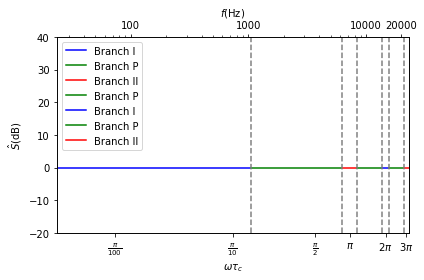

In [7]:
fig, ax1 = plt.subplots()

# Primary x-axis (w*tc)
for omega1, omega2, f1, f2, color, branch in bands:
    ax1.plot([omega1, omega2], [0, 0], color=color, label=branch)
    ax1.axvline(omega1, linestyle='--', color='gray')

ax1.set_xscale('log')
ax1.set_xlim(1 / 100, bands[-1][1])
ax1.set_xticks([np.pi / 100, np.pi / 10, np.pi / 2, np.pi, 2 * np.pi, 3 * np.pi])
ax1.set_xticklabels([r'$\frac{\pi}{100}$', r'$\frac{\pi}{10}$', r'$\frac{\pi}{2}$', r'$\pi$', r'$2\pi$', r'$3\pi$'])

ax1.xaxis.set_minor_locator(ticker.NullLocator())

# Calculate corresponding frequency ticks
major_freq_ticks = [100, 1000, 10000, 20000]
major_omega_tc_ticks = [2 * np.pi * f * tau_c for f in major_freq_ticks]

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())  # Align with primary x-axis
ax2.set_xscale('log')

ax2.set_xticks(major_omega_tc_ticks, minor=False)
ax2.set_xticklabels([str(f) for f in major_freq_ticks])

minor_freq_ticks = (
    list(range(30, 100, 10))    +   # 30, 40, ... , 90
    list(range(200, 1000, 100)) +   # 200, 300, ..., 900
    list(range(2000, 10000, 1000))  # 2000, 3000, ..., 9000
)
minor_omega_tc_ticks = [2 * np.pi * f * tau_c for f in minor_freq_ticks]
ax2.set_xticks(minor_omega_tc_ticks, minor=True)  # set minor ticks
ax2.tick_params(axis='x', which='minor', top=True, labeltop=False)

ax1.legend(loc='upper left')
ax1.set_xlabel(r'$\omega \tau_c$')
ax1.set_ylabel(r'$\hat{S}(\mathrm{dB})$')
ax2.set_xlabel(r'$f(\mathrm{Hz})$')

plt.ylim(-20, 40)
plt.tight_layout()
plt.show()

$$
\chi_{\textrm{I},\textrm{II}}^{[O]}(\omega) = \mp \frac{\mp \gamma x^2+(g^2+1)(x\gamma\pm\sqrt{g^2\mp x+1})}{|x|(\gamma g^2 \mp \gamma x + \gamma - \sqrt{g^2 \mp x + 1})}
$$

$$
\chi_{\textrm{I}}^{[O]}(\omega) = - \frac{- \gamma x^2+(g^2+1)(x\gamma + \sqrt{g^2 - x+1})}{|x|(\gamma g^2 - \gamma x + \gamma - \sqrt{g^2 - x + 1})}
$$
$$
\chi_{\textrm{II}}^{[O]}(\omega) = \frac{ \gamma x^2+(g^2+1)(x\gamma - \sqrt{g^2 + x+1})}{|x|(\gamma g^2 + \gamma x + \gamma - \sqrt{g^2 + x + 1})}
$$

In [8]:
# Calculate spectral amplitudes
# Side image at ipsi ear @Branch I
S_si_ipsi_I  = -(-x*x*r + (g*g+1) * (x*r + np.sqrt(g*g-x+1))) / (np.abs(x) * (r*g*g - r*x + r - np.sqrt(g*g-x+1)))
# Side image at ipsi ear @Branch II
S_si_ipsi_II =  ( x*x*r + (g*g+1) * (x*r - np.sqrt(g*g+x+1))) / (np.abs(x) * (r*g*g + r*x + r - np.sqrt(g*g+x+1)))

/var/folders/27/qgjvyhpn66730t4wymj3hkb80000gn/T/ipykernel_11325/3179941712.py:1: RuntimeWarning: invalid value encountered in log10
  plt.plot(w * tc, 20 * np.log10(S_si_ipsi_I))
/var/folders/27/qgjvyhpn66730t4wymj3hkb80000gn/T/ipykernel_11325/3179941712.py:2: RuntimeWarning: invalid value encountered in log10
  plt.plot(w * tc, 20 * np.log10(S_si_ipsi_II))


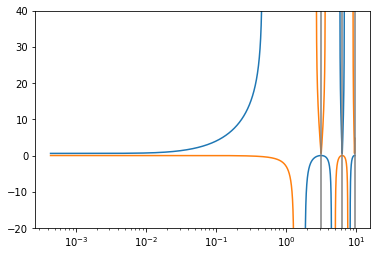

In [9]:
plt.plot(w * tc, 20 * np.log10(S_si_ipsi_I))
plt.plot(w * tc, 20 * np.log10(S_si_ipsi_II))
plt.axvline(1 * np.pi, color='gray')
plt.axvline(2 * np.pi, color='gray')
plt.axvline(3 * np.pi, color='gray')
plt.xscale('log')
plt.ylim(-20, 40)
plt.show()

In [10]:
# Calculate spectral amplitudes
# Side image at ipsi ear @Branch I
E_si_ipsi_I  = ( x*r*r*(g*g-x+1) + (r*r*g+r) * np.sqrt(g*g-x+1)) / (1+g*g-x+2*r*x*np.sqrt(g*g-x+1))
# Side image at ipsi ear @Branch II
E_si_ipsi_II = (-x*r*r*(g*g+x+1) + (r*r*g+r) * np.sqrt(g*g+x+1)) / (1+g*g+x-2*r*x*np.sqrt(g*g+x+1))
# Side image at ipsi ear @Branch Perfect
E_si_ipsi_P  = np.ones_like(w) * r

/var/folders/27/qgjvyhpn66730t4wymj3hkb80000gn/T/ipykernel_11325/771453753.py:1: RuntimeWarning: invalid value encountered in log10
  plt.plot(w * tc, 20 * np.log10(E_si_ipsi_I))
/var/folders/27/qgjvyhpn66730t4wymj3hkb80000gn/T/ipykernel_11325/771453753.py:2: RuntimeWarning: invalid value encountered in log10
  plt.plot(w * tc, 20 * np.log10(E_si_ipsi_II))


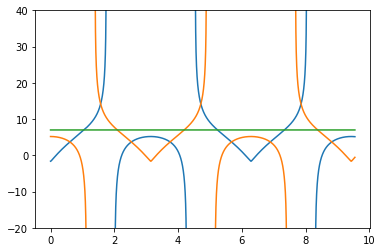

In [11]:
plt.plot(w * tc, 20 * np.log10(E_si_ipsi_I))
plt.plot(w * tc, 20 * np.log10(E_si_ipsi_II))
plt.plot(w * tc, 20 * np.log10(E_si_ipsi_P))
# plt.xscale('log')
# plt.axvline(np.pi)
plt.ylim(-20, 40)
plt.show()

In [12]:
def delta_function(t_values, t_shift):
    """Generates a discrete delta function."""
    delta = np.zeros_like(t_values)
    delta[t_values == t_shift] = 1
    return delta

$$
\psi_0 = -g^2r^2 \delta(t) \pm gr^2 \delta(\tau_c-t) \pm gr^2 \delta(t+\tau_c) -g^2r^2 \delta(t+2\tau_c)
$$

In [13]:
def psi_0(g, r, tau, branch, filter_length):
    t_values = np.arange(-filter_length, filter_length + 1)
    comp1 = -g*g*r*r*delta_function(t_values, 0) 
    comp2 =  g*r*r*delta_function(t_values, tau) 
    comp3 =  g*r*r*delta_function(t_values, -tau) 
    comp4 = -g*g*r*r*delta_function(t_values, -2 * tau)
    if branch == 1:
        return comp1 + comp2 + comp3 + comp4
    if branch == 2:
        return comp1 - comp2 - comp3 + comp4    

$$
\psi_1 = \sum_{m=0}^{\infty} \binom{1/2}{m} (\mp g)^m (g^2 + 1)^{1/2-m} \times \sum_{k=0}^m \binom{m}{k} \delta(2k\tau_c - t - m\tau_c)
$$

In [14]:
def psi_1(g, tau, branch, filter_length):
    t_values = np.arange(-filter_length, filter_length + 1)
    output = np.zeros_like(t_values, dtype=float)
    
    sign = -1 if branch == 1 else 1  

    for m in range(filter_length):
        comp1 = binom(0.5, m) * (sign * g)**m * (g**2 + 1)**(0.5 - m)
        
        for k in range(m + 1):
            comp2 = binom(m, k) * delta_function(t_values, 2 * k * tau - m * tau)
            output += comp1 * comp2 
    
    return output

$$
\psi_2 = \pm \frac{1}{4g\gamma} \sum_{m=0}^{\infty} \binom{-1/2}{m} (-1)^m \times \sum_{k=0}^{2m} \binom{2m}{k} (-1)^{k+m}4^{-m}\delta(t + 2k\tau_c - 2m\tau_c)
$$

In [15]:
def psi_2(g, gamma, tau, branch, filter_length):
    t_values = np.arange(-filter_length, filter_length + 1)
    output = np.zeros_like(t_values, dtype=float)
    
    sign = 1 if branch == 1 else -1 

    prefactor = sign / (4 * g * gamma)  
    
    for m in range(filter_length): 
        comp1 = binom(-0.5, m) * (-1)**m
        
        for k in range(2 * m + 1):
            comp2 = binom(2 * m, k) * (-1)**(k + m) * 4**(-m) * delta_function(t_values, -2 * k * tau + 2 * m * tau)
            output += comp1 * comp2
    
    return prefactor * output

$$
\psi_3 = \sum_{m=0}^{\infty} \binom{-1/2}{m} (\mp g)^m (g^2 + 1)^{1/2-m} \times \sum_{k=0}^m \binom{m}{k} \delta(2k\tau_c - t - m\tau_c)
$$

In [16]:
def psi_3(g, tau, branch, filter_length):
    t_values = np.arange(-filter_length, filter_length + 1)
    output = np.zeros_like(t_values, dtype=float)
    
    sign = -1 if branch == 1 else 1  

    for m in range(filter_length):
        comp1 = binom(-0.5, m) * (sign * g)**m * (g**2 + 1)**(0.5 - m)
        
        for k in range(m + 1):
            comp2 = binom(m, k) * delta_function(t_values, 2 * k * tau - m * tau)
            output += comp1 * comp2 
    
    return output

$$
\psi_4 = 2g\gamma\delta(\tau_c - t) + 2g\gamma\delta(t + \tau_c)
$$

In [17]:
def psi_4(g, gamma, tau, filter_length):
    t_values = np.arange(-filter_length, filter_length + 1)
    
    comp1 = 2 * g * gamma * delta_function(t_values, tau)
    comp2 = 2 * g * gamma * delta_function(t_values, -tau)
    
    return comp1 + comp2

$$
\psi_5 = \pm \frac{1}{(4g\gamma)^3} \sum_{m=0}^{\infty} \binom{-3/2}{m} (-1)^m \times \sum_{k=0}^{2m} \binom{2m}{k} (-1)^{k+m}4^{-m}\delta(t + 2k\tau_c - 2m\tau_c)
$$

In [18]:
def psi_5(g, gamma, tau, branch, filter_length):
    t_values = np.arange(-filter_length, filter_length + 1)
    output = np.zeros_like(t_values, dtype=float)
    
    sign = 1 if branch == 1 else -1 

    prefactor = sign / (4 * g * gamma)**3 
    
    for m in range(filter_length): 
        comp1 = binom(-1.5, m) * (-1)**m
        
        for k in range(2 * m + 1):
            comp2 = binom(2 * m, k) * (-1)**(k + m) * 4**(-m) * delta_function(t_values, -2 * k * tau + 2 * m * tau)
            output += comp1 * comp2
    
    return prefactor * output

$$
\psi_6(c) = \sum_{p=0}^{\infty} \left(\pm\frac{c}{2g}\right)^p \sum_{n=0}^{\infty} \binom{-p/2}{n} (-1)^n \times \sum_{k=0}^{2n} \binom{2n}{k} (-1)^{k+n}4^{-n}\delta(t + 2k\tau_c - 2n\tau_c)
$$

In [19]:
def psi_6(c, g, tau, branch, filter_length):
    t_values = np.arange(-filter_length, filter_length + 1)
    output = np.zeros_like(t_values, dtype=float)
    
    sign = 1 if branch == 1 else -1  

    for p in range(filter_length):  
        coef_p = (sign * c / (2 * g)) ** p  
        
        for n in range(filter_length):  
            coef_n = binom(-p/2, n) * (-1)**n 
            for k in range(2 * n + 1):
                coef_k = binom(2 * n, k) * (-1)**(k + n) * 4**(-n)  
                comp = coef_k * delta_function(t_values, - 2 * k * tau + 2 * n * tau)
                output += coef_p * coef_n * comp 
    
    return output

$$
\begin{align}
c_1 &=  \frac{\sqrt{16\gamma^2(g^2 + 1) + 1} \mp 1}{8\gamma^2} \\
c_2 &= -\frac{\sqrt{16\gamma^2(g^2 + 1) + 1} \mp 1}{8\gamma^2} \\
\end{align}
$$

In [20]:
def compute_c1_c2(g, gamma, branch):
    sqrt_term = np.sqrt(16 * gamma**2 * (g**2 + 1) + 1)
    
    sign = -1 if branch == 1 else 1  
    
    c1 = (sqrt_term + sign) / (8 * gamma**2)
    c2 = -c1
    
    return c1, c2

$$
\psi_a = \pm\psi_2 * \psi_3 \pm (\psi_1 \mp \psi_4) * \psi_5 * \psi_6(c_1) * \psi_6(c_2)
$$

In [21]:
def psi_a(psi1, psi2, psi3, psi4, psi5, psi_6_c1, psi_6_c2, branch):
    sign_pm = 1 if branch == 1 else -1  # plus minus ±
    sign_mp = -1 if branch == 1 else 1  # minus plus ∓
    
    term1 = sign_pm * convolve(psi2, psi3, mode='same')  

    term2_inner = convolve(psi1 + sign_mp * psi4, psi5, mode='same')
    term2_inner = convolve(term2_inner, psi_6_c1, mode='same')
    term2_inner = convolve(term2_inner, psi_6_c2, mode='same')
    
    term2 = sign_pm * term2_inner 

    return term1 + term2

In [26]:
branch = 1
filter_length = 10
# psi0 = psi_0(g, r, tau_s, branch, filter_length)
# psi1 = psi_1(g, tau_s, branch, filter_length)
# psi2 = psi_2(g, r, tau_s, branch, filter_length)
# psi3 = psi_3(g, tau_s, branch, filter_length)
# psi4 = psi_4(g, r, tau_s, filter_length)
# psi5 = psi_5(g, r, tau_s, branch, filter_length)
# c1, c2 = compute_c1_c2(g, r, branch)
# psi6c1 = psi_6(c1, g, tau_s, branch, filter_length)
# psi6c2 = psi_6(c1, g, tau_s, branch, filter_length)
binom(-1, 0)
# for p in range(filter_length):  
#     for n in range(filter_length):  
#         coef_n = binom(-p/2, n) * (-1)**n 
#         print(p, n, coef_n)

nan